In [18]:
import tensorflow as tf
from tensorflow.keras import backend as K

import datetime
import numpy as np
import matplotlib.pyplot as plt

from utils import *

In [19]:
# set precision (default is 'float32')
K.set_floatx('float64')

In [20]:
def LBrot90(f, k=1):
    return tf.concat([f[:,0,None], tf.roll(f[:,1:5], k, axis=-1),
                      tf.roll(f[:,5: ], k, axis=-1)], axis=-1)

def LBmirror(f):
    return tf.concat([f[:,0, None], f[:,1, None], f[:,4, None],
                      f[:,3, None], f[:,2, None], f[:,8, None],
                      f[:,7, None], f[:,6, None], f[:,5, None]], axis=-1)

class D4Symmetry(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(D4Symmetry, self).__init__(**kwargs)

    def call(self, x):
        y = [x, LBrot90(x, k=1), LBrot90(x, k=2), LBrot90(x, k=3),
              LBmirror(x), LBmirror(LBrot90(x, k=1)),
              LBmirror(LBrot90(x, k=2)), LBmirror(LBrot90(x, k=3))]
        return y

class D4AntiSymmetry(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(D4AntiSymmetry, self).__init__(**kwargs)

    def call(self, x):
        y = [x[0], LBrot90(x[1], k=-1), LBrot90(x[2], k=-2), LBrot90(x[3], k=-3),
              LBmirror(x[4]), LBrot90(LBmirror(x[5]), k=-1),
              LBrot90(LBmirror(x[6]), k=-2), LBrot90(LBmirror(x[7]), k=-3)]
        return y

class AlgReconstruction(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AlgReconstruction, self).__init__(**kwargs)

    def call(self, fpre, fpred):
        df  = fpred - fpre
        df2 = -(df[:,0]+2*df[:,3]+  df[:,4]+2*df[:,6]+2*df[:,7])
        df5 = 0.5*(df[:,0]+3*df[:,3]+2*df[:,4]+2*df[:,6]+4*df[:,7]-df[:,1])
        df8 = -0.5*(df[:,0]+  df[:,1]+  df[:,3]+2*df[:,4]+2*df[:,7])

        df = tf.concat([df[:, 0, None], df[:, 1, None], df2[:,None],
                        df[:, 3, None], df[:, 4, None], df5[:,None],
                        df[:, 6, None], df[:, 7, None], df8[:,None]], axis=-1)
        res = fpre + df
        return res

In [21]:
##########################################################
# Import trained model from file

model = tf.keras.models.load_model("example_network.keras", 
                                   custom_objects = {
                                        'rmsre': rmsre,
                                        'D4Symmetry': D4Symmetry,
                                        'D4AntiSymmetry': D4AntiSymmetry,
                                        'AlgReconstruction': AlgReconstruction
                                    }
                                  )

model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 9)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ d4_symmetry_2       │ [(None, 9),       │          0 │ input_layer_3[0]… │
│ (D4Symmetry)        │ (None, 9), (None, │            │                   │
│                     │ 9), (None, 9),    │            │                   │
│                     │ (None, 9), (None, │            │                   │
│                     │ 9), (None, 9),    │            │                   │
│                     │ (None, 9)]        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 9)         │      5,900 │ d4_symmetry_2[0]… │
│ (Sequential)        │                   │            │ d4_symmetry_2[0]… │
│                     │                   │            │ d4_symmetry_2[0]… │
│                     │                   │            │ d4_symmetry_2[0]… │
│                     │                   │            │ d4_symmetry_2[0]… │
│                     │                   │            │ d4_symmetry_2[0]… │
│                     │                   │            │ d4_symmetry_2[0]… │
│                     │                   │            │ d4_symmetry_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ alg_reconstruction… │ (None, 9)         │          0 │ d4_symmetry_2[0]… │
│ (AlgReconstruction) │                   │            │ sequential_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ alg_reconstruction… │ (None, 9)         │          0 │ d4_symmetry_2[0]… │
│ (AlgReconstruction) │                   │            │ sequential_1[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ alg_reconstruction… │ (None, 9)         │          0 │ d4_symmetry_2[0]… │
│ (AlgReconstruction) │                   │            │ sequential_1[2][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ alg_reconstruction… │ (None, 9)         │          0 │ d4_symmetry_2[0]… │
│ (AlgReconstruction) │                   │            │ sequential_1[3][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ alg_reconstruction… │ (None, 9)         │          0 │ d4_symmetry_2[0]… │
│ (AlgReconstruction) │                   │            │ sequential_1[4][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ alg_reconstruction… │ (None, 9)         │          0 │ d4_symmetry_2[0]… │
│ (AlgReconstruction) │                   │            │ sequential_1[5][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ alg_reconstruction… │ (None, 9)         │          0 │ d4_symmetry_2[0]… │
│ (AlgReconstruction) │                   │            │ sequential_1[6][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ alg_reconstruction… │ (None, 9)         │          0 │ d4_symmetry_2[0]… │
│ (AlgReconstruction) │                   │            │ sequential_1[7][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ d4_anti_symmetry_2  │ [(None, 9),       │          0 │ alg_reconstructi… │
│ (D4AntiSymmetry)    │ (None, 9), (None, │            │ alg_reconstructi… │
│                     │ 9), (None, 9),    │            │ alg_reconstructi… │
│                     │ (None, 9), (None, │            │ alg_reconstructi… │
│                     │ 9), (None, 9),    │            │ alg_reconstructi… │
│                     │ (None, 9)]        │            │ alg_reconstructi

 Total params: 17,702 (138.30 KB)

 Trainable params: 5,900 (46.09 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 11,802 (92.20 KB)

In [22]:
###########################################################
# Simulation Parameters

nx      = 32   # grid size along x
ny      = 32   # grid size along y
niter   = 1000  # total number of steps
dumpit  = 100    # collect data every dumpit iterations
tau     = 1.0  # relaxation time
u0      = 0.01 # initial velocity amplitude

verbose = 0

In [23]:
###########################################################
# Collect stats
ndumps   = int(niter//dumpit)
dumpfile = np.zeros( (ndumps*nx*ny, 4 ) ) 
###########################################################


def data_collector(dumpfile, t, ux, uy, rho):
    it   = t // dumpit
    idx0 =  it   *(nx*ny)
    idx1 = (it+1)*(nx*ny)
    dumpfile[idx0:idx1, 0] = t
    dumpfile[idx0:idx1, 1] = rho.reshape(nx*ny)
    dumpfile[idx0:idx1, 2] = ux.reshape( nx*ny)
    dumpfile[idx0:idx1, 3] = uy.reshape( nx*ny)


In [24]:
##########################################################
# Set Initial conditions

a = b = 1.0

ix, iy = np.meshgrid(range(nx), range(ny), indexing='ij')

x = 2.0*np.pi*(ix / nx)
y = 2.0*np.pi*(iy / ny)

ux =  1.0 * u0 * np.sin(a*x) * np.cos(b*y);
uy = -1.0 * u0 * np.cos(a*x) * np.sin(b*y);

rho = np.ones( (nx, ny))

###########################################################
# Lattice velocities and weights
Q = 9
c, w, cs2, compute_feq = LB_stencil()

###########################################################
# Lattice 
feq = np.zeros((nx, ny, Q))
feq = compute_feq(feq, rho, ux, uy, c, w)

f1 = np.copy(feq)
f2 = np.copy(feq)

In [25]:
###########################################################

data_collector(dumpfile, 0, ux, uy, rho)

###########################################################

m_initial = np.sum(f1.flatten())

###########################################################
# Loop on time steps
for t in range(1, niter):

    # streaming
    for ip in range(Q):
        f1[:, :, ip] = np.roll(np.roll(f2[:, :, ip], c[ip, 0], axis=0), c[ip, 1], axis=1)

    # Calculate density
    rho = np.sum(f1, axis=2)

    # Calculate velocity
    ux = (1./rho)*np.einsum('ijk,k', f1, c[:,0]) 
    uy = (1./rho)*np.einsum('ijk,k', f1, c[:,1])                   

    #########################################
    # ML collision step
    #########################################
    
    # Normalize input data
    fpre = f1.reshape( (nx*ny, Q) )
    norm = np.sum(fpre, axis=1)[:,np.newaxis]
    fpre = fpre / norm

    # Make prediction
    f2 = model.predict( fpre, verbose=verbose)

    # Rescale output
    f2 = norm*f2
    f2 = f2.reshape( (nx, ny, Q) )
    
    #########################################
    
    # Collect data
    if (t % dumpit) == 0: 
        data_collector(dumpfile, t, ux, uy, rho)
        
m_final = np.sum(f2.flatten())


print('Sim ended. Mass err:', np.abs(m_initial-m_final)/m_initial)        

Sim ended. Mass err: 0.0


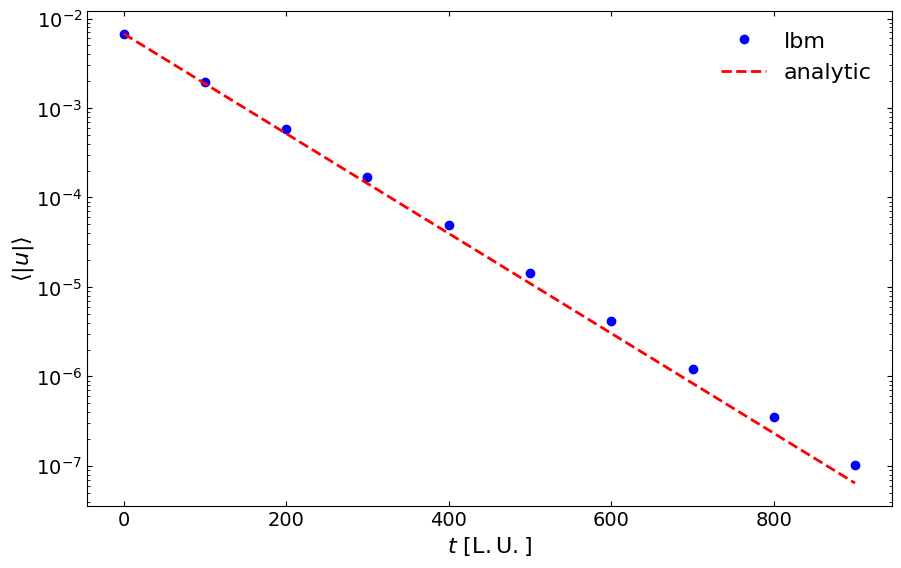

In [26]:
w=3.46*3
h=2.14*3

###################################################################

def sol(t, L, F0, nu): return F0*np.exp(-2*nu*t / (L / (2*np.pi))**2  )

###################################################################

fig = plt.figure(figsize=(w,h))
ax  = fig.add_subplot(111)

tLst = np.arange(0, niter, dumpit)

for i, t in enumerate( tLst ):

    ux  = dumpfile[dumpfile[:,0]==t, 2]
    uy  = dumpfile[dumpfile[:,0]==t, 3]

    Ft = np.average( (ux**2 + uy**2)**0.5  ) 

    if i == 0:
        F0 = Ft 
        ax.semilogy( t, Ft, 'ob', label='lbm')
    else:
        ax.semilogy( t, Ft, 'ob')

nu = (tau-0.5)*(cs2)

ax.semilogy(tLst, sol(tLst, nx, F0, nu), linewidth=2.0, linestyle='--', color='r' , label='analytic')

###################################################################

ax.set_xlabel(r'$t~\rm{[L.U.]}$'      , fontsize=16)
ax.set_ylabel(r'$\langle |u| \rangle$', fontsize=16, rotation=90, labelpad=0)

ax.legend(loc='best', frameon=False, prop={'size' : 16})

ax.tick_params(which="both",direction="in",top="on",right="on",labelsize=14)

plt.show()

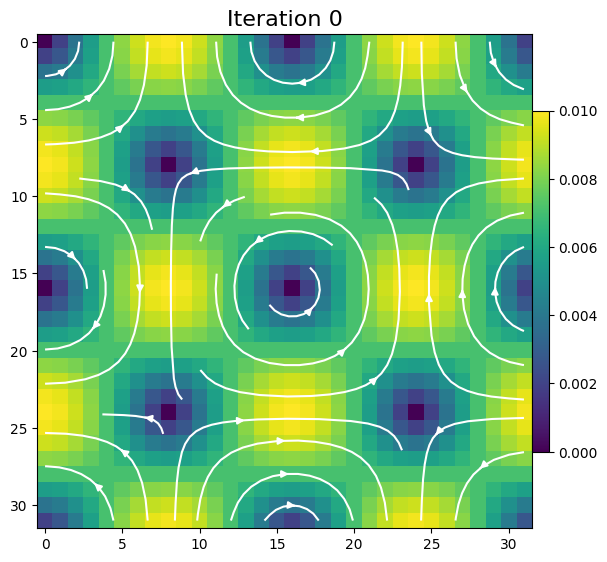

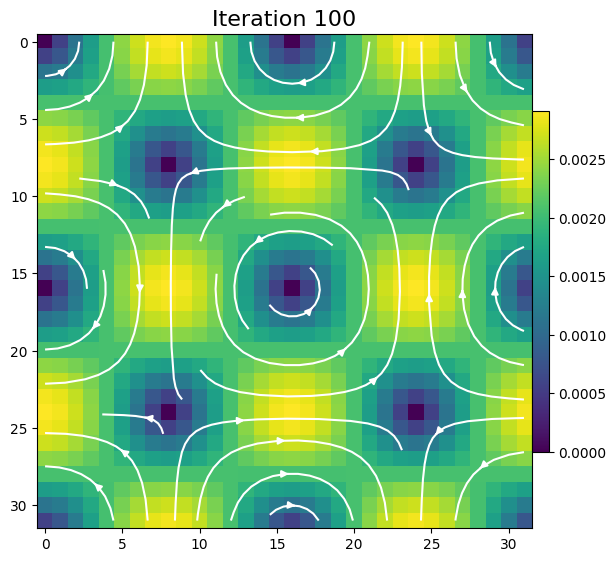

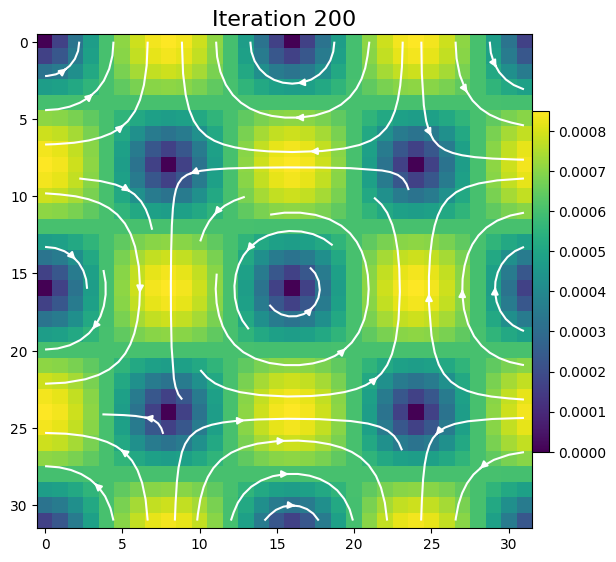

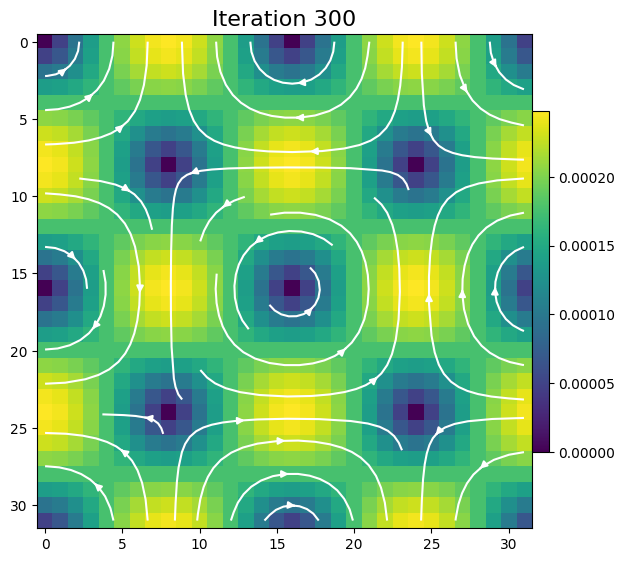

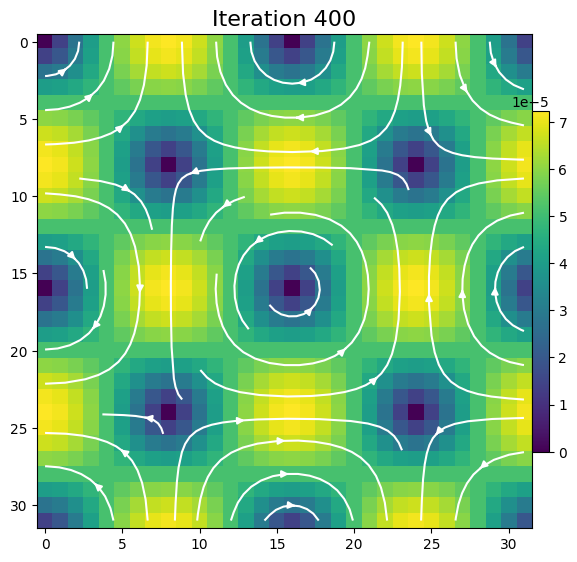

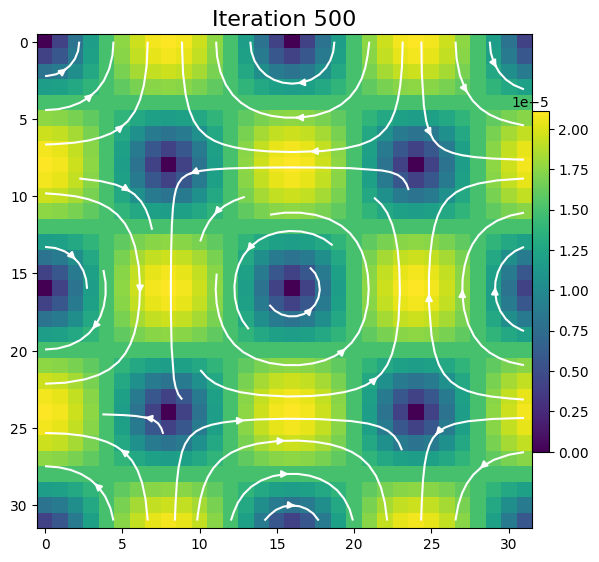

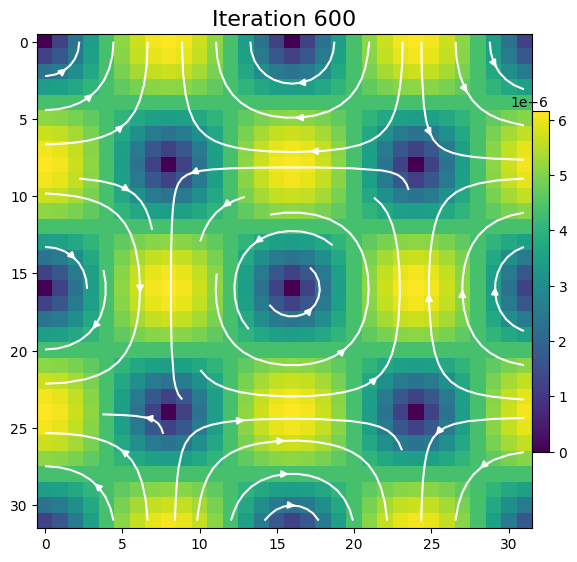

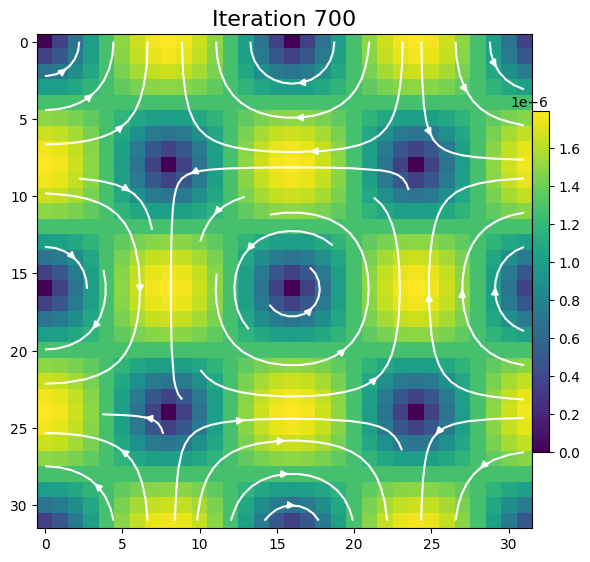

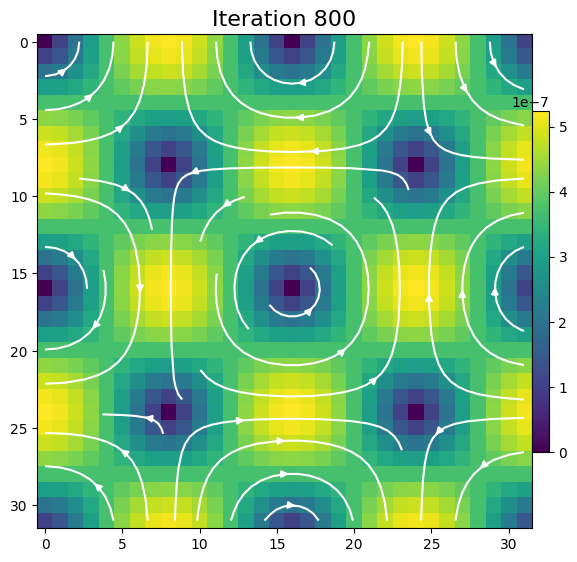

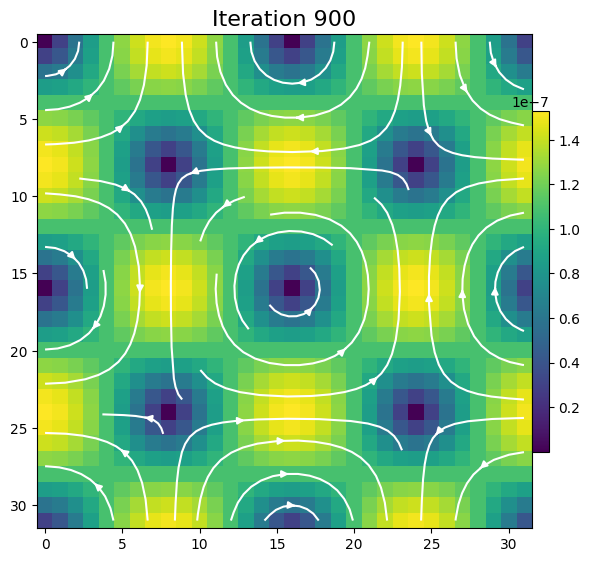

In [27]:
w=3.46*3
h=2.14*3

X, Y = np.meshgrid(np.arange(0, nx), 
                   np.arange(0, ny)
                   )

tLst = np.arange(0, niter, dumpit)

for i, t in enumerate( tLst ):
    
    fig = plt.figure(figsize=(w,h))
    ax  = fig.add_subplot(111)    
    
    ux  = dumpfile[dumpfile[:,0]==t, 2].reshape( (nx,ny) )
    uy  = dumpfile[dumpfile[:,0]==t, 3].reshape( (nx,ny) )    
    
    u = (ux**2 + uy**2)**0.5
    
    vmin=0
    vmax=1e-2
    
    im = ax.imshow(u)#, vmax=vmax, vmin=vmin)
    
    ax.streamplot(X, Y, ux, uy, density = 0.5, color='w')
    
    fig.colorbar(im, ax=ax, orientation='vertical', pad=0, shrink=0.69)
    
    ax.set_title(f"Iteration {t}", size=16)
    
    plt.show()